In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import scipy

import tasks.stats
import tasks.postprocessing
import tasks.graphs

In [2]:
tqdm.tqdm.pandas()
sns.set(style="whitegrid")

In [3]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [4]:
full_df = tasks.postprocessing.get_main_dataset()
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,4,3,False
1,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
2,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
3,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
4,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,4,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57316,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57317,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57318,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57319,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False


In [5]:
no_hardocoded_df = full_df[full_df.model != "hardcoded"]

In [6]:
no_mod_df = no_hardocoded_df.copy()
no_mod_df = no_mod_df[~no_mod_df.is_moderator]
contains_mod = no_mod_df.conv_variant != "No Moderator"
no_mod_df.loc[contains_mod, "message_order"] = (
    no_mod_df[contains_mod].message_order // 2 + 1
)

## Aggregated Analysis

### User intent impact on toxicity

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_barplot.png


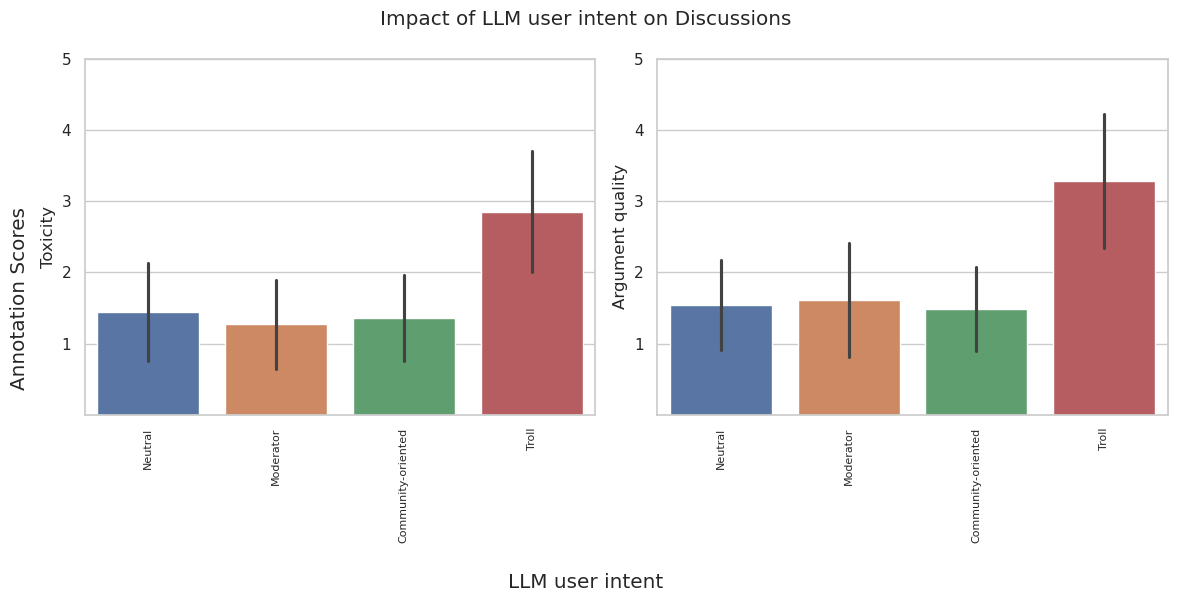

In [7]:
tasks.graphs.plot_metrics_barplots(
    df=no_hardocoded_df,
    group_by_col="intent",
    group_by_col_label="LLM user intent",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "intent_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_barplot.png


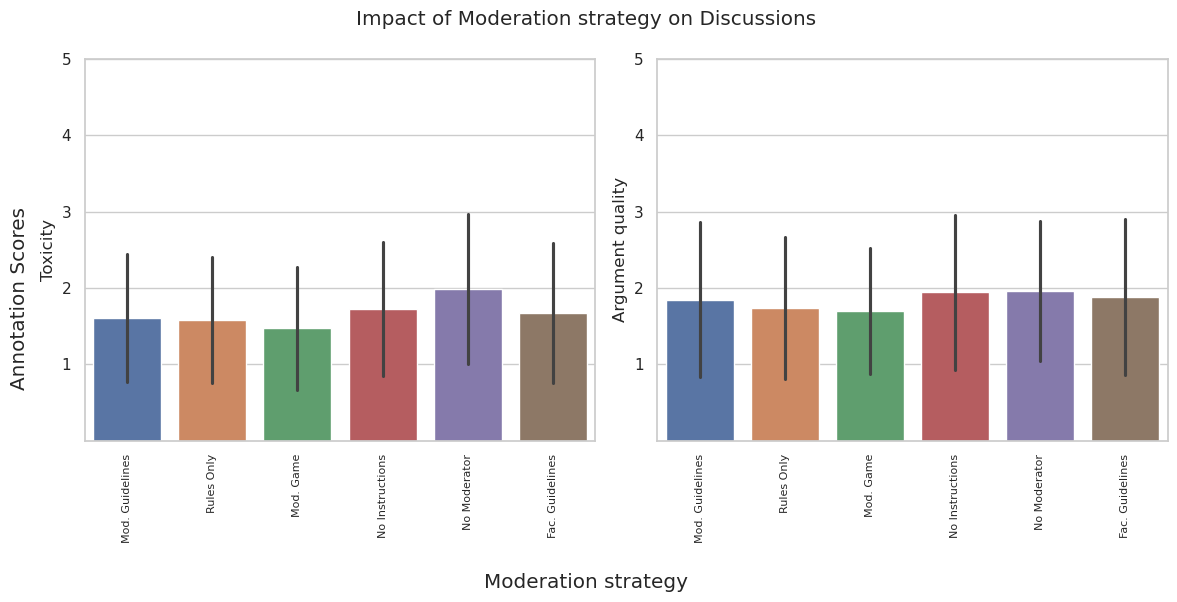

In [8]:
tasks.graphs.plot_metrics_barplots(
    df=no_mod_df,
    group_by_col="conv_variant",
    group_by_col_label="Moderation strategy",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "strategy_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/model_barplot.png


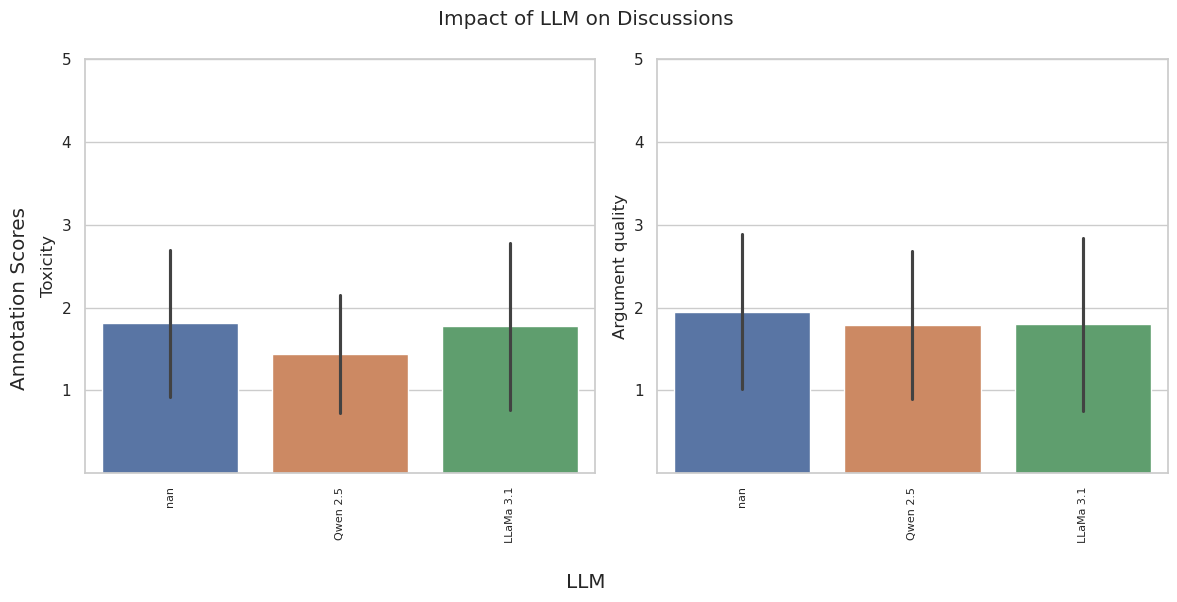

In [9]:
tasks.graphs.plot_metrics_barplots(
    df=no_mod_df,
    group_by_col="model",
    group_by_col_label="LLM",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "model_barplot.png")
plt.show()

## Toxicity by model

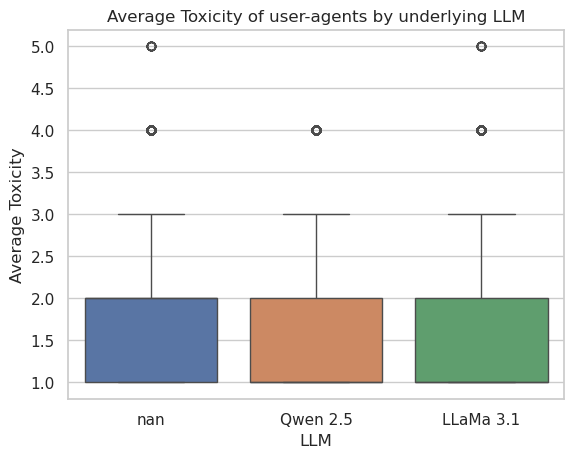

In [10]:
sns.boxplot(data=no_mod_df, x="model", y="Toxicity", hue="model")
plt.title("Average Toxicity of user-agents by underlying LLM")
plt.ylabel("Average Toxicity")
plt.xlabel("LLM")
plt.legend("", frameon=False)
plt.show()

In [11]:
groups = [
    no_mod_df[no_mod_df.model == model].Toxicity.values
    for model in no_mod_df.model.unique()
]
scipy.stats.f_oneway(*groups)

F_onewayResult(statistic=386.8776360461232, pvalue=8.790624321950186e-166)

In [12]:
sp.posthoc_ttest(
    no_mod_df, val_col="Toxicity", group_col="model", p_adjust="holm"
)

,nan,Qwen 2.5,LLaMa 3.1
nan,1.000000e+00,1.279271e-162,3.427775e-02
Qwen 2.5,1.279271e-162,1.000000e+00,6.148880e-114
LLaMa 3.1,3.427775e-02,6.148880e-114,1.000000e+00


In [13]:
[
    no_mod_df[no_mod_df.model == model].Toxicity.mean()
    for model in no_mod_df.model.unique()
]

[1.808306277056277, 1.4371403912543153, 1.7749858836815358]

## Goad

In [14]:
def conv_trolls_exist(df: pd.DataFrame) -> pd.DataFrame:
    trolls_exist = (
        df.groupby("conv_id")["intent"]
        .apply(lambda x: np.any(x == "Troll"))
        .reset_index()
    )
    trolls_exist = trolls_exist.rename(columns={"intent": "trolls_exist"})
    trolls_df = df.merge(trolls_exist, on="conv_id")
    return trolls_df


trolls_df = conv_trolls_exist(no_mod_df)
# exclude troll posts to check if other comments become more toxic
trolls_df = trolls_df[trolls_df.intent != "Troll"]

trolls_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened,trolls_exist
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,2,Mod. Guidelines,nan,CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@SkepticalInvestor77, you're missing the point...",2,2,False,True
1,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,2,Mod. Guidelines,nan,CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@SkepticalInvestor77, you're missing the point...",3,2,False,True
2,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,2,Mod. Guidelines,nan,CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@SkepticalInvestor77, you're missing the point...",3,2,False,True
3,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,2,Mod. Guidelines,nan,CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@SkepticalInvestor77, you're missing the point...",2,2,False,True
4,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,2,Mod. Guidelines,nan,CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@SkepticalInvestor77, you're missing the point...",3,2,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21423,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1394900428090388415,15,Fac. Guidelines,Qwen 2.5,WanderlustNomad22,You are a human participating in an online cha...,False,Neutral,"@NatureLover88, I totally agree with you about...",1,1,False,True
21424,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1394900428090388415,15,Fac. Guidelines,Qwen 2.5,WanderlustNomad22,You are a human participating in an online cha...,False,Neutral,"@NatureLover88, I totally agree with you about...",1,1,False,True
21425,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1394900428090388415,15,Fac. Guidelines,Qwen 2.5,WanderlustNomad22,You are a human participating in an online cha...,False,Neutral,"@NatureLover88, I totally agree with you about...",1,1,False,True
21426,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1394900428090388415,15,Fac. Guidelines,Qwen 2.5,WanderlustNomad22,You are a human participating in an online cha...,False,Neutral,"@NatureLover88, I totally agree with you about...",1,1,False,True


In [15]:
scipy.stats.ttest_ind(
    trolls_df[trolls_df.trolls_exist].Toxicity.values,
    trolls_df[~trolls_df.trolls_exist].Toxicity.values,
)

TtestResult(statistic=20.613772920866214, pvalue=2.604961280622086e-93, df=17609.0)

In [16]:
scipy.stats.ttest_ind(
    trolls_df[trolls_df.trolls_exist]["Argument Quality"].values,
    trolls_df[~trolls_df.trolls_exist]["Argument Quality"].values,
)

TtestResult(statistic=14.899678517423514, pvalue=6.669768771190731e-50, df=17609.0)

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/boxplot_toxicity_original.png


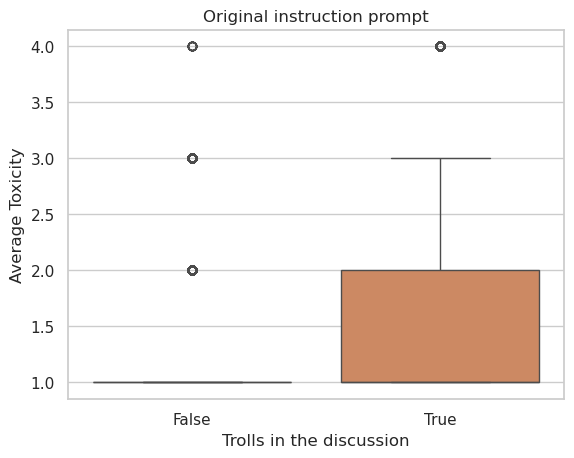

In [17]:
tasks.graphs.trolls_boxplot(
    trolls_df, "Original instruction prompt", val_col="Toxicity"
)
tasks.graphs.save_plot(
    path=tasks.constants.GRAPH_OUTPUT_DIR / "boxplot_toxicity_original.png"
)
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/boxplot_aq_original.png


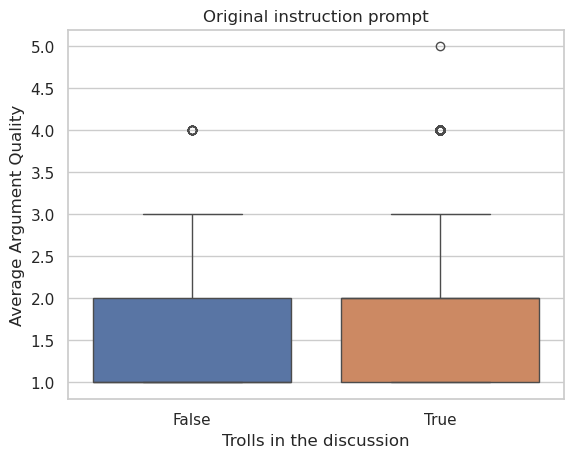

In [18]:
tasks.graphs.trolls_boxplot(
    trolls_df, "Original instruction prompt", val_col="Argument Quality"
)
tasks.graphs.save_plot(
    path=tasks.constants.GRAPH_OUTPUT_DIR / "boxplot_aq_original.png"
)
plt.show()

## Instruction prompt impact on toxicity

In [19]:
basic_instr_df = pd.read_csv(
    "../data/datasets/abl_no_instructions_toxicity.csv"
)
basic_instr_df = tasks.postprocessing.format_dataset(
    basic_instr_df, min_message_len=1
)
basic_instr_df = basic_instr_df[~basic_instr_df.is_moderator]
basic_instr_df.head()

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,841278236907755236,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,4,5,False
1,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,841278236907755236,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,4,5,False
2,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,841278236907755236,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,4,5,False
3,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,841278236907755236,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,4,4,False
4,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,841278236907755236,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,5,5,False


In [20]:
basic_instr_troll_df = conv_trolls_exist(basic_instr_df)
basic_instr_troll_df = basic_instr_troll_df[
    basic_instr_troll_df.intent != "Troll"
]
basic_instr_troll_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened,trolls_exist
0,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,841278236907755236,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,4,5,False,True
1,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,841278236907755236,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,4,5,False,True
2,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,841278236907755236,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,4,5,False,True
3,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,841278236907755236,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,4,4,False,True
4,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,841278236907755236,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,5,5,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,f150149b-3fb5-4f32-9cb2-ec37851e4874,1450238099782659826,28,nan,Qwen 2.5,LostInThought52,You are a human participating in an online cha...,False,Neutral,@RuralFarmer56 I completely agree! The art of ...,1,1,False,False
1316,f150149b-3fb5-4f32-9cb2-ec37851e4874,1450238099782659826,28,nan,Qwen 2.5,LostInThought52,You are a human participating in an online cha...,False,Neutral,@RuralFarmer56 I completely agree! The art of ...,1,1,False,False
1317,f150149b-3fb5-4f32-9cb2-ec37851e4874,1450238099782659826,28,nan,Qwen 2.5,LostInThought52,You are a human participating in an online cha...,False,Neutral,@RuralFarmer56 I completely agree! The art of ...,1,1,False,False
1318,f150149b-3fb5-4f32-9cb2-ec37851e4874,1450238099782659826,28,nan,Qwen 2.5,LostInThought52,You are a human participating in an online cha...,False,Neutral,@RuralFarmer56 I completely agree! The art of ...,1,1,False,False


In [21]:
scipy.stats.ttest_ind(
    basic_instr_troll_df[basic_instr_troll_df.trolls_exist].Toxicity.values,
    basic_instr_troll_df[~basic_instr_troll_df.trolls_exist].Toxicity.values,
)

TtestResult(statistic=4.769565757969146, pvalue=2.08968185847376e-06, df=1120.0)

In [22]:
scipy.stats.ttest_ind(
    basic_instr_troll_df[basic_instr_troll_df.trolls_exist][
        "Argument Quality"
    ].values,
    basic_instr_troll_df[~basic_instr_troll_df.trolls_exist][
        "Argument Quality"
    ].values,
)

TtestResult(statistic=6.439975352058713, pvalue=1.7696711777135863e-10, df=1120.0)

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/boxplot_toxicity_basic.png


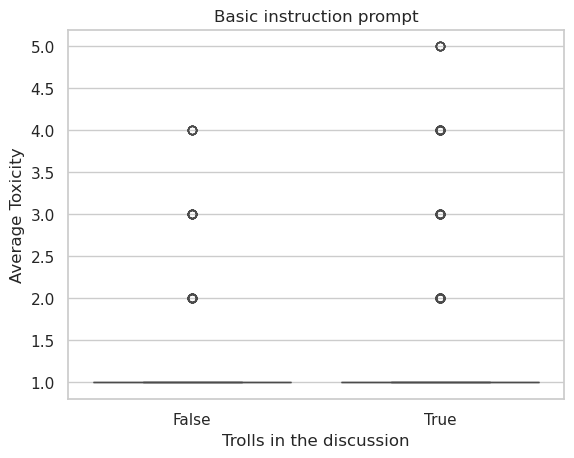

In [23]:
tasks.graphs.trolls_boxplot(
    basic_instr_troll_df, "Basic instruction prompt", val_col="Toxicity"
)
tasks.graphs.save_plot(
    path=tasks.constants.GRAPH_OUTPUT_DIR / "boxplot_toxicity_basic.png"
)
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/boxplot_aq_basic.png


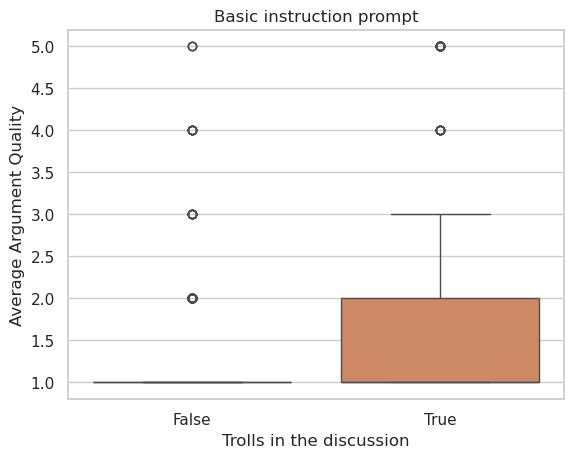

In [24]:
tasks.graphs.trolls_boxplot(
    basic_instr_troll_df,
    "Basic instruction prompt",
    val_col="Argument Quality",
)
tasks.graphs.save_plot(
    path=tasks.constants.GRAPH_OUTPUT_DIR / "boxplot_aq_basic.png"
)
plt.show()